In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq
import flwr as fl
from typing import Optional, Tuple

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

tf.config.run_functions_eagerly(True)

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_test = x_test[6000:10000]
y_test = y_test[6000:10000]


x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 4000


In [3]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [4]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 811


In [5]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

In [6]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)

In [7]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


In [8]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [9]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

In [10]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [11]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

In [12]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [13]:
model_circuit, model_readout = create_quantum_model()

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(model_circuit, model_readout),
])

In [15]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [16]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [17]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [18]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
quantum_model_history = {'loss': [], 'accuracy': []}


def get_eval_fn(model, x_test_data, y_test_data, model_history):
    """Return an evaluation function for server-side evaluation."""
    def evaluate(weights: fl.common.Weights) -> Optional[Tuple[float, float]]:
        model.set_weights(weights)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(x_test_data, y_test_data)
        model_history['loss'].append(loss)
        model_history['accuracy'].append(accuracy)
        return loss, {"accuracy": accuracy}

    return evaluate


strategy = fl.server.strategy.FedAvg(
    eval_fn=get_eval_fn(model, x_test_tfcirc, y_test, quantum_model_history),
    fraction_eval=1,
    min_eval_clients=3,
    min_available_clients=3,
)

In [21]:
fl.server.start_server(config={"num_rounds": 5}, strategy=strategy)

INFO flower 2021-12-24 17:12:25,064 | app.py:80 | Flower server running (insecure, 5 rounds)
INFO flower 2021-12-24 17:12:25,064 | server.py:118 | Initializing global parameters
INFO flower 2021-12-24 17:12:25,064 | server.py:304 | Requesting initial parameters from one random client
INFO flower 2021-12-24 17:12:56,222 | server.py:307 | Received initial parameters from one random client
INFO flower 2021-12-24 17:12:56,223 | server.py:120 | Evaluating initial parameters


 1/26 [>.............................] - ETA: 3s - loss: 1.0224 - hinge_accuracy: 0.3125

/home/frost/anaconda3/envs/fqml/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


26/26 [==============================] - 2s 74ms/step - loss: 1.0158 - hinge_accuracy: 0.4302


INFO flower 2021-12-24 17:12:58,251 | server.py:127 | initial parameters (loss, other metrics): 1.0111913681030273, {'accuracy': 0.47650787234306335}
INFO flower 2021-12-24 17:12:58,251 | server.py:133 | FL starting
DEBUG flower 2021-12-24 17:13:28,896 | server.py:255 | fit_round: strategy sampled 2 clients (out of 3)
DEBUG flower 2021-12-24 17:14:48,419 | server.py:264 | fit_round received 2 results and 0 failures


26/26 [==============================] - 2s 75ms/step - loss: 0.8066 - hinge_accuracy: 0.8596


INFO flower 2021-12-24 17:14:50,387 | server.py:154 | fit progress: (1, 0.8065661787986755, {'accuracy': 0.8595935106277466}, 112.13548542399985)
INFO flower 2021-12-24 17:14:50,388 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2021-12-24 17:14:50,388 | server.py:255 | fit_round: strategy sampled 2 clients (out of 3)
DEBUG flower 2021-12-24 17:16:14,759 | server.py:264 | fit_round received 2 results and 0 failures


26/26 [==============================] - 2s 76ms/step - loss: 0.5329 - hinge_accuracy: 0.8620


INFO flower 2021-12-24 17:16:16,779 | server.py:154 | fit progress: (2, 0.5329183340072632, {'accuracy': 0.8619973659515381}, 198.52661371700015)
INFO flower 2021-12-24 17:16:16,779 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2021-12-24 17:16:16,780 | server.py:255 | fit_round: strategy sampled 2 clients (out of 3)
DEBUG flower 2021-12-24 17:17:38,322 | server.py:264 | fit_round received 2 results and 0 failures


26/26 [==============================] - 2s 86ms/step - loss: 0.3715 - hinge_accuracy: 0.8716


INFO flower 2021-12-24 17:17:40,594 | server.py:154 | fit progress: (3, 0.3714523911476135, {'accuracy': 0.8716127872467041}, 282.342039688001)
INFO flower 2021-12-24 17:17:40,595 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2021-12-24 17:17:40,595 | server.py:255 | fit_round: strategy sampled 2 clients (out of 3)
DEBUG flower 2021-12-24 17:19:00,781 | server.py:264 | fit_round received 2 results and 0 failures


26/26 [==============================] - 2s 75ms/step - loss: 0.3197 - hinge_accuracy: 0.8716


INFO flower 2021-12-24 17:19:02,755 | server.py:154 | fit progress: (4, 0.3197277784347534, {'accuracy': 0.8716127872467041}, 364.5029470490008)
INFO flower 2021-12-24 17:19:02,755 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2021-12-24 17:19:02,756 | server.py:255 | fit_round: strategy sampled 2 clients (out of 3)
DEBUG flower 2021-12-24 17:20:23,871 | server.py:264 | fit_round received 2 results and 0 failures


26/26 [==============================] - 2s 75ms/step - loss: 0.3090 - hinge_accuracy: 0.8704


INFO flower 2021-12-24 17:20:25,852 | server.py:154 | fit progress: (5, 0.30895328521728516, {'accuracy': 0.8704108595848083}, 447.599754846)
INFO flower 2021-12-24 17:20:25,852 | server.py:199 | evaluate_round: no clients selected, cancel
INFO flower 2021-12-24 17:20:25,852 | server.py:172 | FL finished in 447.60050407200106
INFO flower 2021-12-24 17:20:25,853 | app.py:119 | app_fit: losses_distributed []
INFO flower 2021-12-24 17:20:25,853 | app.py:120 | app_fit: metrics_distributed {}
INFO flower 2021-12-24 17:20:25,854 | app.py:121 | app_fit: losses_centralized [(0, 1.0111913681030273), (1, 0.8065661787986755), (2, 0.5329183340072632), (3, 0.3714523911476135), (4, 0.3197277784347534), (5, 0.30895328521728516)]
INFO flower 2021-12-24 17:20:25,854 | app.py:122 | app_fit: metrics_centralized {'accuracy': [(0, 0.47650787234306335), (1, 0.8595935106277466), (2, 0.8619973659515381), (3, 0.8716127872467041), (4, 0.8716127872467041), (5, 0.8704108595848083)]}


In [23]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

simple_model_history = {'loss': [], 'accuracy': []}


strategy = fl.server.strategy.FedAvg(
    eval_fn=get_eval_fn(model, x_test_bin, y_test, simple_model_history),
    fraction_eval=0.2,
    min_eval_clients=3,
    min_available_clients=3,
)

In [24]:
fl.server.start_server(config={"num_rounds": 5}, strategy=strategy)

INFO flower 2021-12-24 17:21:33,064 | app.py:80 | Flower server running (insecure, 5 rounds)
INFO flower 2021-12-24 17:21:33,065 | server.py:118 | Initializing global parameters
INFO flower 2021-12-24 17:21:33,065 | server.py:304 | Requesting initial parameters from one random client
INFO flower 2021-12-24 17:22:17,067 | server.py:307 | Received initial parameters from one random client
INFO flower 2021-12-24 17:22:17,068 | server.py:120 | Evaluating initial parameters


26/26 [==============================] - 0s 3ms/step - loss: 0.7104 - accuracy: 0.6023


INFO flower 2021-12-24 17:22:17,189 | server.py:127 | initial parameters (loss, other metrics): 0.7207560539245605, {'accuracy': 0.596794068813324}
INFO flower 2021-12-24 17:22:17,190 | server.py:133 | FL starting
DEBUG flower 2021-12-24 17:23:08,945 | server.py:255 | fit_round: strategy sampled 2 clients (out of 3)
DEBUG flower 2021-12-24 17:23:09,768 | server.py:264 | fit_round received 2 results and 0 failures


26/26 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.5487


INFO flower 2021-12-24 17:23:09,877 | server.py:154 | fit progress: (1, 0.6686300039291382, {'accuracy': 0.5487052798271179}, 52.68718355400051)
INFO flower 2021-12-24 17:23:09,878 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2021-12-24 17:23:09,878 | server.py:255 | fit_round: strategy sampled 2 clients (out of 3)
DEBUG flower 2021-12-24 17:23:10,736 | server.py:264 | fit_round received 2 results and 0 failures


26/26 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.5808


INFO flower 2021-12-24 17:23:10,838 | server.py:154 | fit progress: (2, 0.6349549293518066, {'accuracy': 0.5807644724845886}, 53.64840169800118)
INFO flower 2021-12-24 17:23:10,839 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2021-12-24 17:23:10,839 | server.py:255 | fit_round: strategy sampled 2 clients (out of 3)
DEBUG flower 2021-12-24 17:23:11,638 | server.py:264 | fit_round received 2 results and 0 failures


26/26 [==============================] - 0s 3ms/step - loss: 0.5936 - accuracy: 0.7398


INFO flower 2021-12-24 17:23:11,751 | server.py:154 | fit progress: (3, 0.5935975313186646, {'accuracy': 0.7398273944854736}, 54.56110801000068)
INFO flower 2021-12-24 17:23:11,751 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2021-12-24 17:23:11,752 | server.py:255 | fit_round: strategy sampled 2 clients (out of 3)
DEBUG flower 2021-12-24 17:23:12,611 | server.py:264 | fit_round received 2 results and 0 failures


26/26 [==============================] - 0s 3ms/step - loss: 0.5414 - accuracy: 0.7694


INFO flower 2021-12-24 17:23:12,732 | server.py:154 | fit progress: (4, 0.5413713455200195, {'accuracy': 0.7694204449653625}, 55.5421220900007)
INFO flower 2021-12-24 17:23:12,733 | server.py:199 | evaluate_round: no clients selected, cancel
DEBUG flower 2021-12-24 17:23:12,733 | server.py:255 | fit_round: strategy sampled 2 clients (out of 3)
DEBUG flower 2021-12-24 17:23:13,597 | server.py:264 | fit_round received 2 results and 0 failures


26/26 [==============================] - 0s 3ms/step - loss: 0.4869 - accuracy: 0.8767


INFO flower 2021-12-24 17:23:13,702 | server.py:154 | fit progress: (5, 0.48689746856689453, {'accuracy': 0.876695454120636}, 56.512302415001614)
INFO flower 2021-12-24 17:23:13,703 | server.py:199 | evaluate_round: no clients selected, cancel
INFO flower 2021-12-24 17:23:13,703 | server.py:172 | FL finished in 56.51300638400062
INFO flower 2021-12-24 17:23:13,703 | app.py:119 | app_fit: losses_distributed []
INFO flower 2021-12-24 17:23:13,704 | app.py:120 | app_fit: metrics_distributed {}
INFO flower 2021-12-24 17:23:13,704 | app.py:121 | app_fit: losses_centralized [(0, 0.7207560539245605), (1, 0.6686300039291382), (2, 0.6349549293518066), (3, 0.5935975313186646), (4, 0.5413713455200195), (5, 0.48689746856689453)]
INFO flower 2021-12-24 17:23:13,705 | app.py:122 | app_fit: metrics_centralized {'accuracy': [(0, 0.596794068813324), (1, 0.5487052798271179), (2, 0.5807644724845886), (3, 0.7398273944854736), (4, 0.7694204449653625), (5, 0.876695454120636)]}


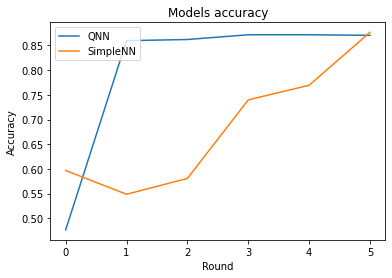

In [25]:
from matplotlib import pyplot as plt
plt.plot(quantum_model_history['accuracy'])
plt.plot(simple_model_history['accuracy'])
plt.title('Models accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Round')
plt.legend(['QNN', 'SimpleNN'], loc='upper left')
plt.show()

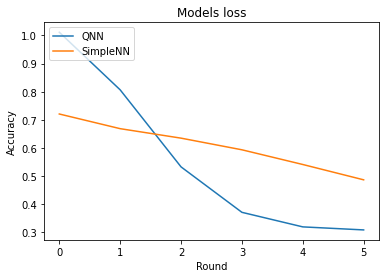

In [26]:
from matplotlib import pyplot as plt
plt.plot(quantum_model_history['loss'])
plt.plot(simple_model_history['loss'])
plt.title('Models loss')
plt.ylabel('Accuracy')
plt.xlabel('Round')
plt.legend(['QNN', 'SimpleNN'], loc='upper left')
plt.show()